In [ ]:
import numpy as np
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import regularizers
from sklearn.neural_network import BernoulliRBM


class DBN():
    def __init__(
            self,
            x_train,
            y_train,
            x_test,
            y_test,
            hidden_layer,
            learning_rate_rbm=0.0001,
            batch_size_rbm=100,
            n_epochs_rbm=30,
            verbose_rbm=1,
            random_seed_rbm=1300,
            activation_function_nn='relu',
            learning_rate_nn=0.005,
            batch_size_nn=100,
            n_epochs_nn=10,
            verbose_nn=1,
            decay_rate=0):

            self.x_train = x_train
            self.y_train = y_train
            self.x_test = x_test
            self.y_test = y_test
            self.hidden_layer = hidden_layer
            self.learning_rate_rbm = learning_rate_rbm
            self.batch_size_rbm = batch_size_rbm
            self.n_epochs_rbm = n_epochs_rbm
            self.verbose_rbm = verbose_rbm
            self.random_seed = random_seed_rbm
            self.activation_function_nn = activation_function_nn
            self.learning_rate_nn = learning_rate_nn
            self.batch_size_nn = batch_size_nn
            self.n_epochs_nn = n_epochs_nn
            self.verbose_nn = verbose_nn
            self.decay_rate = decay_rate
            self.weight_rbm = []
            self.bias_rbm = []
            self.test_rms = 0
            self.result = []
            self.model = Sequential()

    def pretraining(self):
        input_layer = self.x_train
        for i in range(len(self.hidden_layer)):
            print("DBN Layer {0} Pre-training".format(i + 1))
            rbm = BernoulliRBM(n_components=self.hidden_layer[i],
                               learning_rate=self.learning_rate_rbm,
                               batch_size=self.batch_size_rbm,
                               n_iter=self.n_epochs_rbm,
                               verbose=self.verbose_rbm,
                               random_state=self.verbose_rbm)
            rbm.fit(input_layer)
            # size of weight matrix is [input_layer, hidden_layer]
            self.weight_rbm.append(rbm.components_.T)
            self.bias_rbm.append(rbm.intercept_hidden_)
            input_layer = rbm.transform(input_layer)
        print('Pre-training finish.')

    def finetuning(self):
        print('Fine-tuning start.')

        for i in range(0, len(self.hidden_layer)):
            if i == 0:
                self.model.add(Dense(self.hidden_layer[i], activation=self.activation_function_nn,
                                     input_dim=self.x_train.shape[1]))
            elif i >= 1:
                self.model.add(Dense(self.hidden_layer[i], activation=self.activation_function_nn))
            else:
                pass
            layer = self.model.layers[i]
            layer.set_weights([self.weight_rbm[i], self.bias_rbm[i]])
        if(self.y_train.ndim == 1):
            self.model.add(Dense(1, activation=None, kernel_regularizer=regularizers.l2(0.01)))
        else :
            self.model.add(Dense(self.y_train.shape[1], activation=None))

        sgd = SGD(lr=self.learning_rate_nn, decay=self.decay_rate)
        self.model.compile(loss='mse',
                      optimizer=sgd,
                      )
        self.model.fit(self.x_train, self.y_train, batch_size=self.batch_size_nn,
                       epochs=self.n_epochs_nn, verbose=self.verbose_nn)
        print('Fine-tuning finish.')
        self.test_rms = self.model.evaluate(self.x_test, self.y_test)
        self.result = np.array(self.model.predict(self.x_test))

    def predict(self, series):
        return np.array(self.model.predict(series))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv, to_datetime

input_length = 50
output_length = 1
test_percentage = 0.2


# df_bitcoin = read_csv('/content/drive/MyDrive/coin_Bitcoin.csv')
# df_bitcoin = df_bitcoin.drop(columns=["SNo","Name","Symbol","Volume","Marketcap"])
# import datetime as dt
# df_bitcoin['Date'] = to_datetime(df_bitcoin['Date'])
                                    
# mask = df_bitcoin['Date'].dt.year == int('2019')                                    
# df_bitcoin = df_bitcoin[mask]

# df_bitcoin.index = df_bitcoin["Date"]
df_bitcoin = read_csv('/content/drive/MyDrive/bitcoin_prices.csv')
df_bitcoin = df_bitcoin.dropna()
# import datetime as dt
from datetime import datetime

# timestamp = 1545730073
df_bitcoin['Timestamp'] = df_bitcoin['Timestamp'].apply(lambda d: datetime.fromtimestamp(d))

print( df_bitcoin['Timestamp'])


mask = df_bitcoin['Timestamp'].dt.year == int('2019')                                    
df_bitcoin = df_bitcoin[mask]
print(df_bitcoin.head())
df_bitcoin.index = df_bitcoin["Timestamp"]

dataset = df_bitcoin['Open'].to_numpy()

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)
trainset = dataset_list[:int(len(dataset_list) * (1 - test_percentage))]
testset = dataset_list[int(len(dataset_list) * (1 - test_percentage)):]

x_train = trainset[:, :-1]
y_train = trainset[:, -1:]
x_test = testset[:, :-1]
y_test = testset[:, -1:]

print('x_train.shape:' + str(x_train.shape))
print('y_train.shape:' + str(y_train.shape))
print('x_test.shape:' + str(x_test.shape))
print('y_test.shape' + str(y_test.shape))


0         2011-12-31 07:52:00
478       2011-12-31 15:50:00
547       2011-12-31 16:59:00
548       2011-12-31 17:00:00
1224      2012-01-01 04:16:00
                  ...        
4727772   2020-12-30 23:56:00
4727773   2020-12-30 23:57:00
4727774   2020-12-30 23:58:00
4727775   2020-12-30 23:59:00
4727776   2020-12-31 00:00:00
Name: Timestamp, Length: 3484305, dtype: datetime64[ns]
                  Timestamp     Open  ...  Volume_(Currency)  Weighted_Price
3676576 2019-01-01 00:00:00  3693.85  ...       20301.156505     3696.974936
3676577 2019-01-01 00:01:00  3694.72  ...       35080.265871     3692.600865
3676578 2019-01-01 00:02:00  3689.73  ...        3562.371230     3687.884698
3676579 2019-01-01 00:03:00  3692.85  ...        1095.220713     3691.813285
3676580 2019-01-01 00:04:00  3692.35  ...         412.065433     3691.614849

[5 rows x 8 columns]
x_train.shape:(406631, 50)
y_train.shape:(406631, 1)
x_test.shape:(101658, 50)
y_test.shape(101658, 1)


DBN Layer 1 Pre-training
[BernoulliRBM] Iteration 1, pseudo-likelihood = -34.18, time = 18.44s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -34.14, time = 30.18s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -34.10, time = 29.91s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -34.06, time = 29.89s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -34.01, time = 30.05s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -33.92, time = 29.94s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -33.80, time = 29.83s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -33.58, time = 29.54s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -33.34, time = 29.69s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -32.96, time = 29.67s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -32.51, time = 29.29s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -31.94, time = 29.52s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -31.26, time = 29.31s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -30.51, time

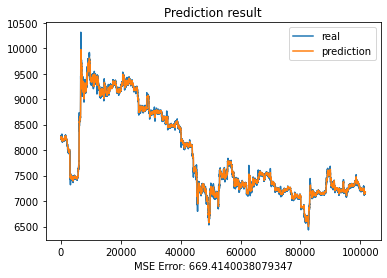

In [ ]:
dbn1 = DBN(x_train=x_train,
                   y_train=y_train,
                   x_test=x_test,
                   y_test=y_test,
                   hidden_layer=[256, 128, 64],
                   learning_rate_rbm=0.0005,
                   batch_size_rbm=150,
                   n_epochs_rbm=200,
                   verbose_rbm=1,
                   random_seed_rbm=500,
                   activation_function_nn='tanh',
                   learning_rate_nn=0.005,
                   batch_size_nn=150,
                   n_epochs_nn=1500,
                   verbose_nn=1,
                   decay_rate=0)
dbn1.pretraining()
dbn1.finetuning()
# dataset_pred = dbn1.result[:, 0]
# dataset_test = dataset[0, dataset.shape[1] - testnum:dataset.shape[1]]
# mse = mean_squared_error(dataset_pred, dataset_test)
# plt.figure(figsize=(12, 9), dpi=100)
# plt.plot(dataset_test)
# plt.plot(dataset_pred)
# plt.legend(['dataset_real', 'dataset_prediction'], loc='upper right')
# plt.title('sequence prediction result', fontsize=16)
# plt.xlabel('MSE = %f' % mse)
# plt.draw()
y_predict = dbn1.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()
    #plt.show()
    # return dataset_pred, mse

In [ ]:
dbn1.model.save("/content/drive/MyDrive/dbn1.h5")

In [ ]:
import keras
dbn2 = keras.models.load_model('/content/drive/MyDrive/dbn1.h5')

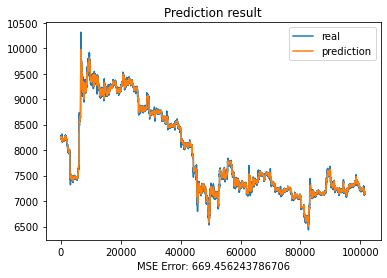

In [ ]:
y_predict = dbn2.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()
    #plt.sh

In [ ]:
acc = ((1 - np.mean(abs(y_real -y_predict)/y_real)))
# print(np.mean(abs(y_real -y_predict)/y_real))
print(acc)

0.9981173818387911


In [ ]:

acc = np.mean((1-100 * (abs(y_real -y_predict)/y_real)))
print(acc)

0.8117381838791056


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

0.9990725562818753


In [ ]:
rmse=np.sqrt(np.mean(((y_predict -y_real )**2)))
print(rmse)

25.87385425485058


In [ ]:
dbn2.evaluate(x_test,y_test)

3177/3177 [==============================] - 4s 1ms/step - loss: 6.0499e-06


6.04993874731008e-06

In [ ]:
print(mean_squared_error(y_real, y_predict))

669.4140038079347


In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real, y_predict))

14.826782064119085


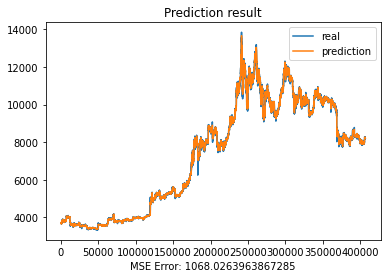

In [ ]:
y_predict = dbn2.predict(x_train)
y_real = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

In [ ]:
# Hour data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv, to_datetime

input_length = 50
output_length = 1
test_percentage = 0.2


# df_bitcoin = read_csv('/content/drive/MyDrive/coin_Bitcoin.csv')
# df_bitcoin = df_bitcoin.drop(columns=["SNo","Name","Symbol","Volume","Marketcap"])
# import datetime as dt
# df_bitcoin['Date'] = to_datetime(df_bitcoin['Date'])
                                    
# mask = df_bitcoin['Date'].dt.year == int('2019')                                    
# df_bitcoin = df_bitcoin[mask]

# df_bitcoin.index = df_bitcoin["Date"]
df_bitcoin = read_csv('/content/drive/MyDrive/bitcoin_prices.csv')
df_bitcoin = df_bitcoin.dropna()
# import datetime as dt
from datetime import datetime

# timestamp = 1545730073
df_bitcoin['Timestamp'] = df_bitcoin['Timestamp'].apply(lambda d: datetime.fromtimestamp(d))

print( df_bitcoin['Timestamp'])


# mask = df_bitcoin['Timestamp'].dt.year == int('2019') & df_bitcoin['Timestamp'].dt.minute == int('00') & df_bitcoin['Timestamp'].dt.second == int('00')                                    
df_bitcoin = df_bitcoin[(df_bitcoin.Timestamp.dt.year == 2019) & (df_bitcoin.Timestamp.dt.minute == 0)]
# df_bitcoin = df_bitcoin[mask]
print(df_bitcoin.head())
df_bitcoin.index = df_bitcoin["Timestamp"]

dataset = df_bitcoin['Open'].to_numpy()

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)
trainset = dataset_list[:int(len(dataset_list) * (1 - test_percentage))]
testset = dataset_list[int(len(dataset_list) * (1 - test_percentage)):]

x_train = trainset[:, :-1]
y_train = trainset[:, -1:]
x_test = testset[:, :-1]
y_test = testset[:, -1:]

print('x_train.shape:' + str(x_train.shape))
print('y_train.shape:' + str(y_train.shape))
print('x_test.shape:' + str(x_test.shape))
print('y_test.shape' + str(y_test.shape))


0         2011-12-31 07:52:00
478       2011-12-31 15:50:00
547       2011-12-31 16:59:00
548       2011-12-31 17:00:00
1224      2012-01-01 04:16:00
                  ...        
4727772   2020-12-30 23:56:00
4727773   2020-12-30 23:57:00
4727774   2020-12-30 23:58:00
4727775   2020-12-30 23:59:00
4727776   2020-12-31 00:00:00
Name: Timestamp, Length: 3484305, dtype: datetime64[ns]
                  Timestamp     Open  ...  Volume_(Currency)  Weighted_Price
3676576 2019-01-01 00:00:00  3693.85  ...       20301.156505     3696.974936
3676636 2019-01-01 01:00:00  3692.89  ...       17727.680210     3693.789790
3676696 2019-01-01 02:00:00  3681.18  ...        7456.794776     3681.179360
3676756 2019-01-01 03:00:00  3680.84  ...        1474.775366     3680.840000
3676816 2019-01-01 04:00:00  3681.10  ...        8185.774848     3683.792322

[5 rows x 8 columns]
x_train.shape:(6840, 50)
y_train.shape:(6840, 1)
x_test.shape:(1710, 50)
y_test.shape(1710, 1)


DBN Layer 1 Pre-training
[BernoulliRBM] Iteration 1, pseudo-likelihood = -33.30, time = 0.13s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -33.06, time = 0.30s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -32.56, time = 0.27s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -31.15, time = 0.28s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -28.32, time = 0.28s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -26.14, time = 0.27s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -24.73, time = 0.27s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -23.98, time = 0.27s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -23.70, time = 0.28s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -23.49, time = 0.26s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -23.49, time = 0.28s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -23.39, time = 0.27s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -23.47, time = 0.27s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -23.48, time = 0.27s
[Ber

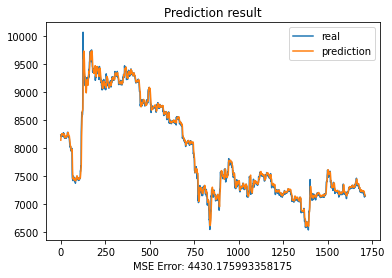

In [ ]:
dbn1 = DBN(x_train=x_train,
                   y_train=y_train,
                   x_test=x_test,
                   y_test=y_test,
                   hidden_layer=[100],
                   learning_rate_rbm=0.01,
                   batch_size_rbm=16,
                   n_epochs_rbm=20,
                   verbose_rbm=1,
                   random_seed_rbm=500,
                   activation_function_nn='relu',
                   learning_rate_nn=0.01,
                   batch_size_nn=16,
                   n_epochs_nn=1500,
                   verbose_nn=1,
                   decay_rate=0)
dbn1.pretraining()
dbn1.finetuning()
dbn1.model.save("/content/drive/MyDrive/dbn_hour_new.h5")
# dataset_pred = dbn1.result[:, 0]
# dataset_test = dataset[0, dataset.shape[1] - testnum:dataset.shape[1]]
# mse = mean_squared_error(dataset_pred, dataset_test)
# plt.figure(figsize=(12, 9), dpi=100)
# plt.plot(dataset_test)
# plt.plot(dataset_pred)
# plt.legend(['dataset_real', 'dataset_prediction'], loc='upper right')
# plt.title('sequence prediction result', fontsize=16)
# plt.xlabel('MSE = %f' % mse)
# plt.draw()
y_predict = dbn1.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()
    #plt.show()
    # return dataset_pred, mse

In [ ]:
rmse=np.sqrt(np.mean(((y_predict -y_real )**2)))
print(rmse)

66.55956725639204


In [ ]:
print(mean_squared_error(y_real, y_predict))

4430.175993358175


In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real, y_predict))

38.44750420321634


In [ ]:
import keras
dbn2 = keras.models.load_model('/content/drive/MyDrive/dbn_hour_new.h5')

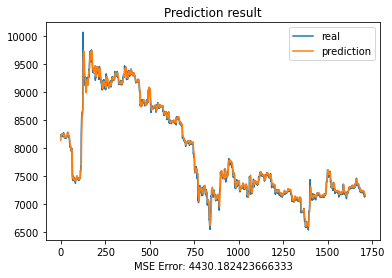

In [ ]:
y_predict = dbn2.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()
    #plt.sh

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

0.9938129968780886


In [ ]:

acc = np.mean((1-100 * (abs(y_real -y_predict)/y_real)))
print(acc)

0.5134177965382994


In [ ]:
acc = ((1 - np.mean(abs(y_real -y_predict)/y_real)))
# print(np.mean(abs(y_real -y_predict)/y_real))
print(acc)

0.995134177965383


In [ ]:
#day

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv, to_datetime

input_length = 5
output_length = 1
test_percentage = 0.2


# df_bitcoin = read_csv('/content/drive/MyDrive/coin_Bitcoin.csv')
# df_bitcoin = df_bitcoin.drop(columns=["SNo","Name","Symbol","Volume","Marketcap"])
# import datetime as dt
# df_bitcoin['Date'] = to_datetime(df_bitcoin['Date'])
                                    
# mask = df_bitcoin['Date'].dt.year == int('2019')                                    
# df_bitcoin = df_bitcoin[mask]

# df_bitcoin.index = df_bitcoin["Date"]
df_bitcoin = read_csv('/content/drive/MyDrive/bitcoin_prices.csv')
df_bitcoin = df_bitcoin.dropna()
# import datetime as dt
from datetime import datetime

# timestamp = 1545730073
df_bitcoin['Timestamp'] = df_bitcoin['Timestamp'].apply(lambda d: datetime.fromtimestamp(d))

print( df_bitcoin['Timestamp'])


# mask = df_bitcoin['Timestamp'].dt.year == int('2019') & df_bitcoin['Timestamp'].dt.minute == int('00') & df_bitcoin['Timestamp'].dt.second == int('00')                                    
df_bitcoin = df_bitcoin[(df_bitcoin.Timestamp.dt.year == 2019) & (df_bitcoin.Timestamp.dt.minute == 0) & (df_bitcoin.Timestamp.dt.hour == 0)]
# df_bitcoin = df_bitcoin[mask]
print(df_bitcoin.head())
df_bitcoin.index = df_bitcoin["Timestamp"]

dataset = df_bitcoin['Open'].to_numpy()

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)
trainset = dataset_list[:int(len(dataset_list) * (1 - test_percentage))]
testset = dataset_list[int(len(dataset_list) * (1 - test_percentage)):]

x_train = trainset[:, :-1]
y_train = trainset[:, -1:]
x_test = testset[:, :-1]
y_test = testset[:, -1:]

print('x_train.shape:' + str(x_train.shape))
print('y_train.shape:' + str(y_train.shape))
print('x_test.shape:' + str(x_test.shape))
print('y_test.shape' + str(y_test.shape))


0         2011-12-31 07:52:00
478       2011-12-31 15:50:00
547       2011-12-31 16:59:00
548       2011-12-31 17:00:00
1224      2012-01-01 04:16:00
                  ...        
4727772   2020-12-30 23:56:00
4727773   2020-12-30 23:57:00
4727774   2020-12-30 23:58:00
4727775   2020-12-30 23:59:00
4727776   2020-12-31 00:00:00
Name: Timestamp, Length: 3484305, dtype: datetime64[ns]
         Timestamp     Open  ...  Volume_(Currency)  Weighted_Price
3676576 2019-01-01  3693.85  ...       20301.156505     3696.974936
3678016 2019-01-02  3825.41  ...       18743.764333     3831.234894
3679456 2019-01-03  3890.27  ...       23632.047356     3890.599049
3680896 2019-01-04  3785.64  ...        8396.296799     3785.425382
3682336 2019-01-05  3822.00  ...       39165.828981     3820.462790

[5 rows x 8 columns]
x_train.shape:(285, 5)
y_train.shape:(285, 1)
x_test.shape:(72, 5)
y_test.shape(72, 1)


DBN Layer 1 Pre-training
[BernoulliRBM] Iteration 1, pseudo-likelihood = -3.43, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3.40, time = 0.01s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -3.41, time = 0.01s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -3.42, time = 0.01s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -3.40, time = 0.01s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -3.41, time = 0.01s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -3.39, time = 0.01s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -3.40, time = 0.01s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -3.40, time = 0.01s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -3.39, time = 0.01s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -3.40, time = 0.01s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -3.41, time = 0.01s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -3.37, time = 0.01s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -3.40, time = 0.01s
[BernoulliRBM] Ite

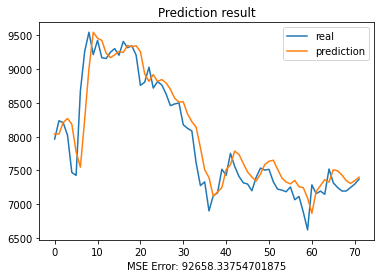

In [ ]:
dbn1 = DBN(x_train=x_train,
                   y_train=y_train,
                   x_test=x_test,
                   y_test=y_test,
                   hidden_layer=[32],
                   learning_rate_rbm=0.01,
                   batch_size_rbm=4,
                   n_epochs_rbm=200,
                   verbose_rbm=1,
                   random_seed_rbm=500,
                   activation_function_nn='relu',
                   learning_rate_nn=0.01,
                   batch_size_nn=4,
                   n_epochs_nn=2000,
                   verbose_nn=1,
                   decay_rate=0)
dbn1.pretraining()
dbn1.finetuning()
# dbn1.model.save("/content/drive/MyDrive/dbn_day.h5")
# dataset_pred = dbn1.result[:, 0]
# dataset_test = dataset[0, dataset.shape[1] - testnum:dataset.shape[1]]
# mse = mean_squared_error(dataset_pred, dataset_test)
# plt.figure(figsize=(12, 9), dpi=100)
# plt.plot(dataset_test)
# plt.plot(dataset_pred)
# plt.legend(['dataset_real', 'dataset_prediction'], loc='upper right')
# plt.title('sequence prediction result', fontsize=16)
# plt.xlabel('MSE = %f' % mse)
# plt.draw()
y_predict = dbn1.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()
    #plt.show()
    # return dataset_pred, mse

In [ ]:
dbn1.model.save("/content/drive/MyDrive/dbn_day_new.h5")

In [ ]:
rmse=np.sqrt(np.mean(((y_predict -y_real )**2)))
print(rmse)

304.39832053909026


In [ ]:
print(mean_squared_error(y_real, y_predict))

92658.33754701875


In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real, y_predict))

220.67674560546877


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

0.8666018350992765


In [ ]:
import keras
dbn2 = keras.models.load_model('/content/drive/MyDrive/dbn_day_new.h5')

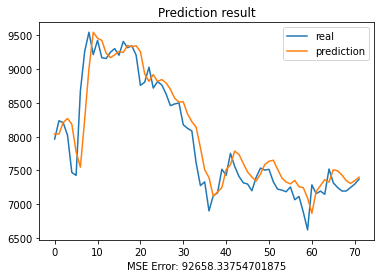

In [ ]:
y_predict = dbn2.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()
    #plt.sh

In [ ]:
acc = ((1 - np.mean(abs(y_real -y_predict)/y_real)))
# print(np.mean(abs(y_real -y_predict)/y_real))
print(acc)

0.9719137372073645


0         2011-12-31 07:52:00
478       2011-12-31 15:50:00
547       2011-12-31 16:59:00
548       2011-12-31 17:00:00
1224      2012-01-01 04:16:00
                  ...        
4727772   2020-12-30 23:56:00
4727773   2020-12-30 23:57:00
4727774   2020-12-30 23:58:00
4727775   2020-12-30 23:59:00
4727776   2020-12-31 00:00:00
Name: Timestamp, Length: 3484305, dtype: datetime64[ns]


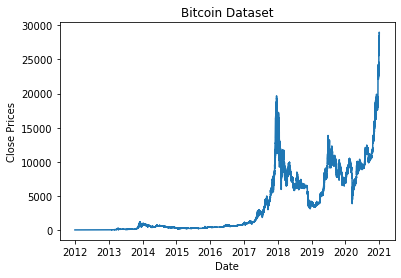

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv, to_datetime

input_length = 50
output_length = 1
test_percentage = 0.2


# df_bitcoin = read_csv('/content/drive/MyDrive/coin_Bitcoin.csv')
# df_bitcoin = df_bitcoin.drop(columns=["SNo","Name","Symbol","Volume","Marketcap"])
# import datetime as dt
# df_bitcoin['Date'] = to_datetime(df_bitcoin['Date'])
                                    
# mask = df_bitcoin['Date'].dt.year == int('2019')                                    
# df_bitcoin = df_bitcoin[mask]

# df_bitcoin.index = df_bitcoin["Date"]
df_bitcoin = read_csv('/content/drive/MyDrive/bitcoin_prices.csv')
df_bitcoin = df_bitcoin.dropna()
# import datetime as dt
from datetime import datetime

# timestamp = 1545730073
df_bitcoin['Timestamp'] = df_bitcoin['Timestamp'].apply(lambda d: datetime.fromtimestamp(d))

print( df_bitcoin['Timestamp'])

df_bitcoin.index = df_bitcoin["Timestamp"]

dataset = df_bitcoin['Open'].to_numpy()

plt.figure(1)
plt.plot(df_bitcoin['Timestamp'], dataset)
plt.xlabel("Date")
plt.ylabel("Close Prices")
plt.title('Bitcoin Dataset')
plt.show()

0         2011-12-31 07:52:00
478       2011-12-31 15:50:00
547       2011-12-31 16:59:00
548       2011-12-31 17:00:00
1224      2012-01-01 04:16:00
                  ...        
4727772   2020-12-30 23:56:00
4727773   2020-12-30 23:57:00
4727774   2020-12-30 23:58:00
4727775   2020-12-30 23:59:00
4727776   2020-12-31 00:00:00
Name: Timestamp, Length: 3484305, dtype: datetime64[ns]
                  Timestamp     Open  ...  Volume_(Currency)  Weighted_Price
3676576 2019-01-01 00:00:00  3693.85  ...       20301.156505     3696.974936
3676577 2019-01-01 00:01:00  3694.72  ...       35080.265871     3692.600865
3676578 2019-01-01 00:02:00  3689.73  ...        3562.371230     3687.884698
3676579 2019-01-01 00:03:00  3692.85  ...        1095.220713     3691.813285
3676580 2019-01-01 00:04:00  3692.35  ...         412.065433     3691.614849

[5 rows x 8 columns]


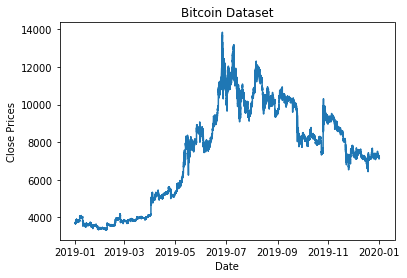

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv, to_datetime

input_length = 50
output_length = 1
test_percentage = 0.2


# df_bitcoin = read_csv('/content/drive/MyDrive/coin_Bitcoin.csv')
# df_bitcoin = df_bitcoin.drop(columns=["SNo","Name","Symbol","Volume","Marketcap"])
# import datetime as dt
# df_bitcoin['Date'] = to_datetime(df_bitcoin['Date'])
                                    
# mask = df_bitcoin['Date'].dt.year == int('2019')                                    
# df_bitcoin = df_bitcoin[mask]

# df_bitcoin.index = df_bitcoin["Date"]
df_bitcoin = read_csv('/content/drive/MyDrive/bitcoin_prices.csv')
df_bitcoin = df_bitcoin.dropna()
# import datetime as dt
from datetime import datetime

# timestamp = 1545730073
df_bitcoin['Timestamp'] = df_bitcoin['Timestamp'].apply(lambda d: datetime.fromtimestamp(d))

print( df_bitcoin['Timestamp'])


mask = df_bitcoin['Timestamp'].dt.year == int('2019')                                    
df_bitcoin = df_bitcoin[mask]
print(df_bitcoin.head())
df_bitcoin.index = df_bitcoin["Timestamp"]

dataset = df_bitcoin['Open'].to_numpy()

plt.figure(1)
plt.plot(df_bitcoin["Timestamp"], dataset)
plt.xlabel("Date")
plt.ylabel("Close Prices")
plt.title('Bitcoin Dataset')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


0         2011-12-31 07:52:00
478       2011-12-31 15:50:00
547       2011-12-31 16:59:00
548       2011-12-31 17:00:00
1224      2012-01-01 04:16:00
                  ...        
4727772   2020-12-30 23:56:00
4727773   2020-12-30 23:57:00
4727774   2020-12-30 23:58:00
4727775   2020-12-30 23:59:00
4727776   2020-12-31 00:00:00
Name: Timestamp, Length: 3484305, dtype: datetime64[ns]
                  Timestamp     Open  ...  Volume_(Currency)  Weighted_Price
3676576 2019-01-01 00:00:00  3693.85  ...       20301.156505     3696.974936
3676636 2019-01-01 01:00:00  3692.89  ...       17727.680210     3693.789790
3676696 2019-01-01 02:00:00  3681.18  ...        7456.794776     3681.179360
3676756 2019-01-01 03:00:00  3680.84  ...        1474.775366     3680.840000
3676816 2019-01-01 04:00:00  3681.10  ...        8185.774848     3683.792322

[5 rows x 8 columns]


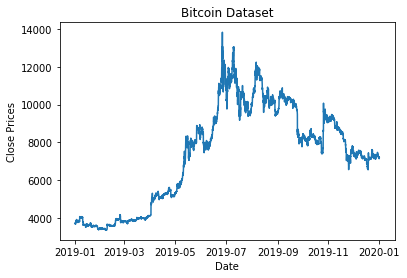

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv, to_datetime

input_length = 50
output_length = 1
test_percentage = 0.2


# df_bitcoin = read_csv('/content/drive/MyDrive/coin_Bitcoin.csv')
# df_bitcoin = df_bitcoin.drop(columns=["SNo","Name","Symbol","Volume","Marketcap"])
# import datetime as dt
# df_bitcoin['Date'] = to_datetime(df_bitcoin['Date'])
                                    
# mask = df_bitcoin['Date'].dt.year == int('2019')                                    
# df_bitcoin = df_bitcoin[mask]

# df_bitcoin.index = df_bitcoin["Date"]
df_bitcoin = read_csv('/content/drive/MyDrive/bitcoin_prices.csv')
df_bitcoin = df_bitcoin.dropna()
# import datetime as dt
from datetime import datetime

# timestamp = 1545730073
df_bitcoin['Timestamp'] = df_bitcoin['Timestamp'].apply(lambda d: datetime.fromtimestamp(d))

print( df_bitcoin['Timestamp'])


# mask = df_bitcoin['Timestamp'].dt.year == int('2019') & df_bitcoin['Timestamp'].dt.minute == int('00') & df_bitcoin['Timestamp'].dt.second == int('00')                                    
df_bitcoin = df_bitcoin[(df_bitcoin.Timestamp.dt.year == 2019) & (df_bitcoin.Timestamp.dt.minute == 0)]
# df_bitcoin = df_bitcoin[mask]
print(df_bitcoin.head())
df_bitcoin.index = df_bitcoin["Timestamp"]

dataset = df_bitcoin['Open'].to_numpy()

plt.figure(1)
plt.plot(df_bitcoin["Timestamp"], dataset)
plt.xlabel("Date")
plt.ylabel("Close Prices")
plt.title('Bitcoin Dataset')
plt.show()


0         2011-12-31 07:52:00
478       2011-12-31 15:50:00
547       2011-12-31 16:59:00
548       2011-12-31 17:00:00
1224      2012-01-01 04:16:00
                  ...        
4727772   2020-12-30 23:56:00
4727773   2020-12-30 23:57:00
4727774   2020-12-30 23:58:00
4727775   2020-12-30 23:59:00
4727776   2020-12-31 00:00:00
Name: Timestamp, Length: 3484305, dtype: datetime64[ns]
         Timestamp     Open  ...  Volume_(Currency)  Weighted_Price
3676576 2019-01-01  3693.85  ...       20301.156505     3696.974936
3678016 2019-01-02  3825.41  ...       18743.764333     3831.234894
3679456 2019-01-03  3890.27  ...       23632.047356     3890.599049
3680896 2019-01-04  3785.64  ...        8396.296799     3785.425382
3682336 2019-01-05  3822.00  ...       39165.828981     3820.462790

[5 rows x 8 columns]


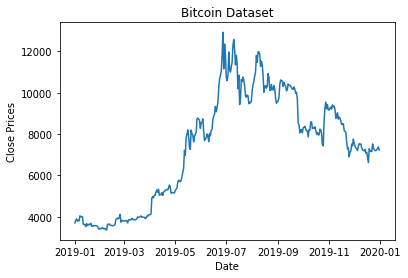

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv, to_datetime

input_length = 5
output_length = 1
test_percentage = 0.2


# df_bitcoin = read_csv('/content/drive/MyDrive/coin_Bitcoin.csv')
# df_bitcoin = df_bitcoin.drop(columns=["SNo","Name","Symbol","Volume","Marketcap"])
# import datetime as dt
# df_bitcoin['Date'] = to_datetime(df_bitcoin['Date'])
                                    
# mask = df_bitcoin['Date'].dt.year == int('2019')                                    
# df_bitcoin = df_bitcoin[mask]

# df_bitcoin.index = df_bitcoin["Date"]
df_bitcoin = read_csv('/content/drive/MyDrive/bitcoin_prices.csv')
df_bitcoin = df_bitcoin.dropna()
# import datetime as dt
from datetime import datetime

# timestamp = 1545730073
df_bitcoin['Timestamp'] = df_bitcoin['Timestamp'].apply(lambda d: datetime.fromtimestamp(d))

print( df_bitcoin['Timestamp'])


# mask = df_bitcoin['Timestamp'].dt.year == int('2019') & df_bitcoin['Timestamp'].dt.minute == int('00') & df_bitcoin['Timestamp'].dt.second == int('00')                                    
df_bitcoin = df_bitcoin[(df_bitcoin.Timestamp.dt.year == 2019) & (df_bitcoin.Timestamp.dt.minute == 0) & (df_bitcoin.Timestamp.dt.hour == 0)]
# df_bitcoin = df_bitcoin[mask]
print(df_bitcoin.head())
df_bitcoin.index = df_bitcoin["Timestamp"]

dataset = df_bitcoin['Open'].to_numpy()

plt.figure(1)
plt.plot(df_bitcoin["Timestamp"], dataset)
plt.xlabel("Date")
plt.ylabel("Close Prices")
plt.title('Bitcoin Dataset')
plt.show()